<h1> Insight Data Challenge </h1>

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

Populating the interactive namespace from numpy and matplotlib


<h1> about the data </h1>

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

<h1> Step 1: load in the data to a pandas DF </h1>

In [2]:
names= ['id', 'Clump_Thickness', 'Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape', 'Marginal_Adhesion',\
        'Single_Epithelial_Cell_Size','Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']

DF=pd.read_csv('/Users/attiladobi/Documents/breast-cancer-wisconsin.data.txt',names=names)
DF=DF.replace('?','0') #clean the data. There are question marks in this columns ... :/
DF['Bare_Nuclei']=DF['Bare_Nuclei'].astype(int)
DF_B=DF[DF['Class']==2].drop('Class',1).drop('id',1)
DF_M=DF[DF['Class']==4].drop('Class',1).drop('id',1)

<h1> I could ... but I'm not using random forest for this <br> Will use profile likelihood analyis (same same, but different) </h1>

<h3> If the variables are independent we can wite L(x,y,z,...)=L(x)*L(y)*L(z)*.. (Naive-Bayes) <br>
I will take the product of the likelihood of each featue because creating a single 9D histogram with 10 bins each is slow (1B entries) </h3>

In [45]:
#generate a list of pdfs for each feature and for each classification type

PDFs_M=[]
for ii in range(np.shape(DF_M)[1]):
    H_M, edges = np.histogram(DF_M.values[:,ii],bins=arange(1,12))
    H_M=H_M/sum(H_M)
    PDFs_M.append(H_M)
    
PDFs_B=[]
for ii in range(np.shape(DF_B)[1]):
    H_B, edges = np.histogram(DF_B.values[:,ii],bins=arange(1,12))
    H_B=H_B/sum(H_B)
    PDFs_B.append(H_B)

<h1> Step 2: Visualize the profiles of all features (profile, aka histogram)</h1>

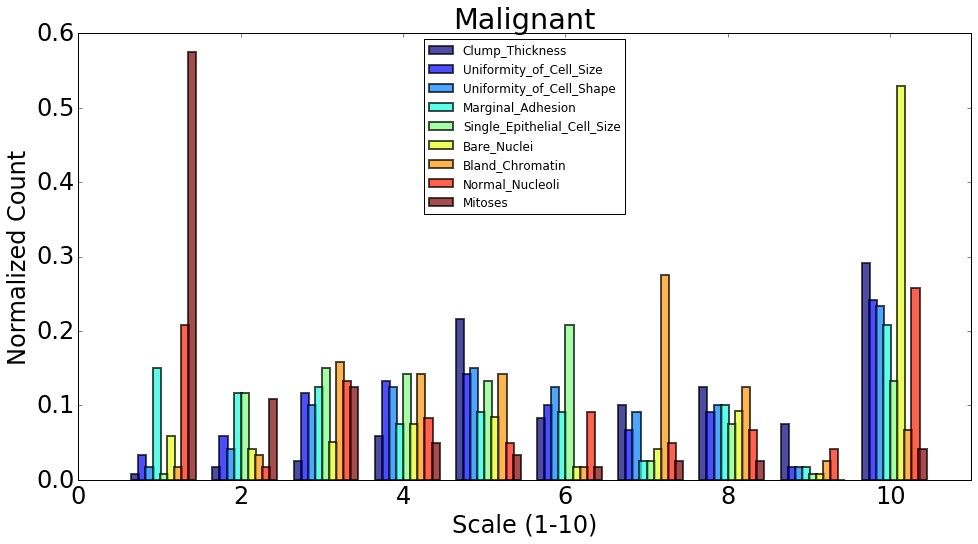

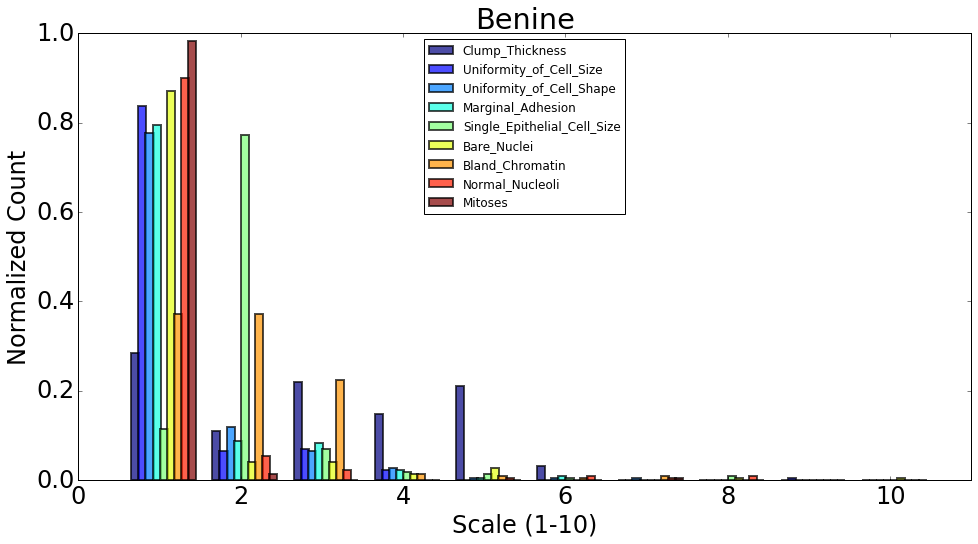

In [404]:
pylab.rcParams['figure.figsize'] = (16.0, 8.0) # set size of figures"
number_of_lines= 9
cm_subsection = linspace(start, stop, number_of_lines) 
colors = [ cm.jet(x) for x in cm_subsection ]
position=linspace(-.35,.35,9)

for ii, pdf in enumerate(PDFs_M):
    bar(edges[:-1]+position[ii],pdf,label=names[ii+1],width=0.1, linewidth=2, color=colors[ii],alpha=0.7)
xlabel('Scale (1-10)')
ylabel('Normalized Count')
plt.legend(fontsize=12,loc='upper center')
xlim([0,11])
plt.title('Malignant')

figure()
pylab.rcParams['figure.figsize'] = (16.0, 8.0) # set size of figures"
number_of_lines= 9
cm_subsection = linspace(start, stop, number_of_lines) 
colors = [ cm.jet(x) for x in cm_subsection ]
position=linspace(-.35,.35,9)

for ii, pdf in enumerate(PDFs_B):
    bar(edges[:-1]+position[ii],pdf,label=names[ii+1],width=0.1, linewidth=2, color=colors[ii],alpha=0.7)
xlabel('Scale (1-10)')
ylabel('Normalized Count')
plt.legend(fontsize=12,loc='upper center')
xlim([0,11])
plt.title('Benine')

The profiles of the benine case are right skewed while the malignant profiles are more uniformly distributed through the 1-10 scale. It appears that bare nuclei (yellow) has the most dramatic change betweent the benine and malignat categorie. At first glace the variable appears to be most insignificant is mitoses (confirmed by the last plot in this notebook).

<h1> Step 3: Use the profiles to calculate the log likelihood ratio (LLR)</h1>

<h1> LLR for Malignat </h1>

In [138]:
N_m=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_B,dataVals)] for dataVals in DF_M.values],1)
D_m=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_M,dataVals)] for dataVals in DF_M.values],1)
LLR_m=N_m-D_m #The log likelihood ratio
#the denominator is malignant because that represents "True positive"

<h1> LLR for Benine </h1>

In [139]:
N_b=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_B,dataVals)] for dataVals in DF_B.values],1)
D_b=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_M,dataVals)] for dataVals in DF_B.values],1)
LLR_b=N_b-D_b #The log likelihood ratio

<h1> Histogram the LLR of each point (labled) to visualize seperation of the two populations</h1>

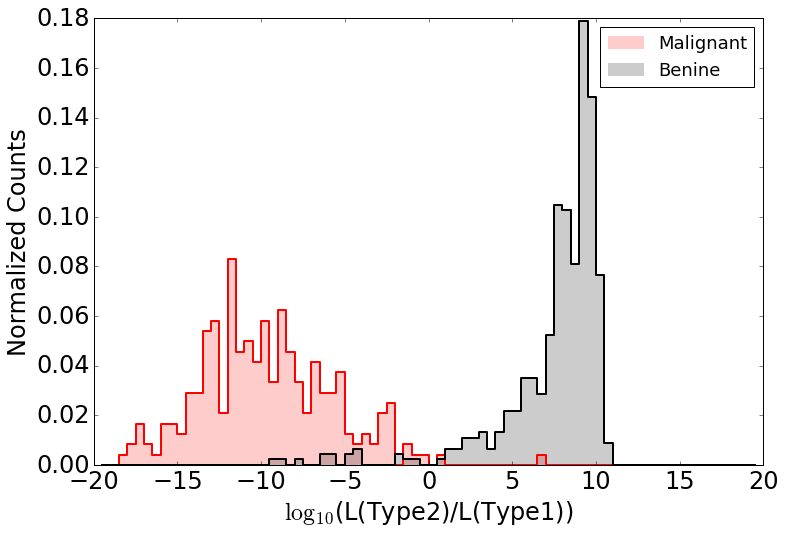

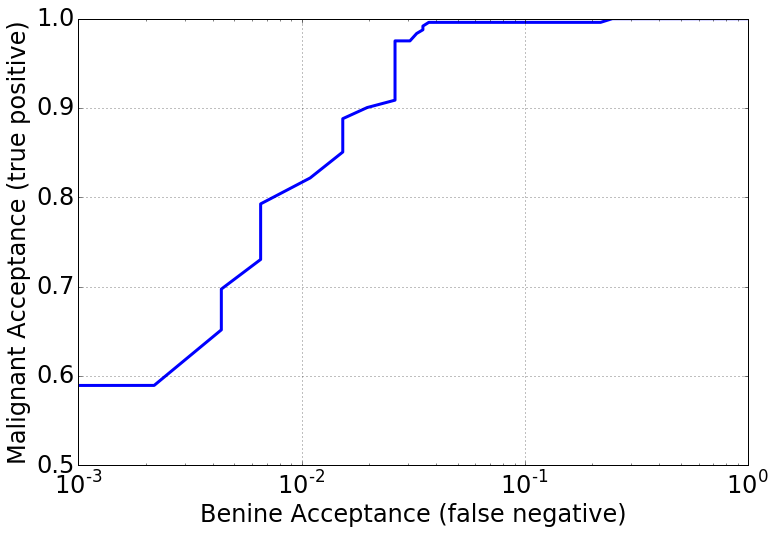

In [141]:
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
#setup the range of the LLR
width=0.5
xbins=np.arange(-20,20,width)

nLLRT1, edgesT1 = histogram(LLR_m,bins=xbins, normed=0)
nLLRT2, edgesT2= histogram(LLR_b,bins=xbins, normed=0)
nLLRT1=nLLRT1/size(LLR_m)
nLLRT2=nLLRT2/size(LLR_b)

plt.bar(edgesT1[:-1], nLLRT1 ,alpha=0.2,label='Malignant',color='r',linewidth=0, width=width)
plt.step(edgesT1[1:],nLLRT1,color='r',linewidth=2)
plt.bar(edgesT2[:-1], nLLRT2 ,alpha=0.2,label='Benine',color='k',linewidth=0, width=width)
plt.step(edgesT2[1:],nLLRT2,color='k',linewidth=2)

#xlim([-100,100])
legend(fontsize=18)
xlabel('$\mathrm{log_{10}}$(L(Type2)/L(Type1))')
ylabel('Normalized Counts')

#savefig('figs/MV_Disc_40-8B.png',dpi=200)
#savefig('figs/MV_Disc_40-8B.pdf')

#make figure of cummulative sum... ROC
figure()
T2Frac=cumsum(nLLRT2)
T1Frac=cumsum(nLLRT1)

plot(T2Frac,T1Frac,linewidth=3)
xlabel('Benine Acceptance (false negative)')
ylabel('Malignant Acceptance (true positive)')
xscale('log')
xlim([1e-3,1])
ylim([0.5,1])
grid('on')


<h1> The optimal boundry is LLR >1 </h1>
<h3> A note: The precission will always be limited to 99% because of the maligent outlier with a likelihood ratio of 6 in the above plot. The classifier will always switch from 99% to 100% precision depending on wheater or not that event falls in the testing set or not. It is the limiting factor when optimizing the precision </h3> 

<h1> Plot the true-positives and false-negatives vs. the log likelihood ratio (LLR) </h1>

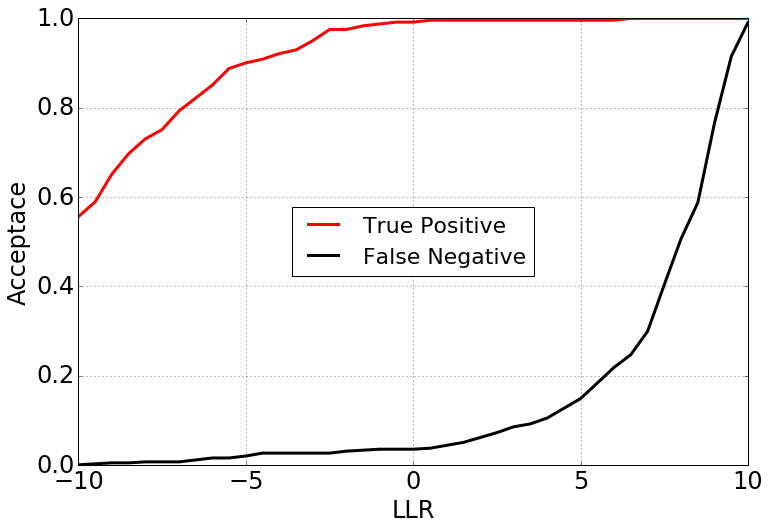

In [377]:
plot(edgesT2[:-1],T1Frac,'r',linewidth=3,label='True Positive')
plot(edgesT2[:-1],T2Frac,'k',linewidth=3,label='False Negative')
plt.xlabel('LLR')
plt.ylabel('Acceptace')
plt.legend(fontsize=22,loc='center')
xlim([-10,10])
grid()

<h1> Step 4: Testing <br> Split the data into 50/50 for training and testing </h1>
<p> Since the PDFs are normalized we don't have to worry about the skewed data, or overtraining </p>

In [407]:
def test_llr(train_frac=0.5,llr_cut=1):
    '''Given a training fraction and llr threshold randomly sample the data, train the algoritm and test,
    compute the precission, recall, and fraction of flase negatives'''
    DF_B_Train=DF_B.sample(int(len(DF_B)*train_frac))
    DF_B_Test=DF_B.loc[DF_B.index.difference(DF_B_Train.index)]

    DF_M_Train=DF_M.sample(int(len(DF_M)*train_frac))
    DF_M_Test=DF_M.loc[DF_M.index.difference(DF_M_Train.index)]
    
    #build PDFs
    PDFs_M=[]
    for ii in range(np.shape(DF_M_Train)[1]):
        H_M, edges = np.histogram(DF_M_Train.values[:,ii],bins=arange(1,12))
        H_M=H_M/sum(H_M)
        PDFs_M.append(H_M)
    
    PDFs_B=[]
    for ii in range(np.shape(DF_B_Train)[1]):
        H_B, edges = np.histogram(DF_B_Train.values[:,ii],bins=arange(1,12))
        H_B=H_B/sum(H_B)
        PDFs_B.append(H_B)
    #Test
    N_m=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_B,dataVals)] for dataVals in DF_M_Test.values],1)
    D_m=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_M,dataVals)] for dataVals in DF_M_Test.values],1)
    LLR_m=N_m-D_m

    N_b=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_B,dataVals)] for dataVals in DF_B_Test.values],1)
    D_b=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip(PDFs_M,dataVals)] for dataVals in DF_B_Test.values],1)
    LLR_b=N_b-D_b
    
    nTP=sum(LLR_m<=llr_cut)
    nFP=sum(LLR_m>llr_cut)
    
    nTN=sum(LLR_b>llr_cut)
    nFN=sum(LLR_b<=llr_cut)
    
    Precission= nTP/(nTP+nFP)
    Recall= nTP/(nTP+nFN)
    Accuracy = (nTP+nTN)/(nTP+nFP+nFN+nTN)
    Frac_FN=sum(LLR_b<=llr_cut)/len(LLR_b)

    return Precission, Recall, Accuracy, Frac_FN

<h1> Train and Test (50/50), resample data 100 times </h1>

In [418]:
Prec,Rec, ACC, FN =[],[],[],[]
for i in range(100):
    prec,rec,acc,fn=test_llr(0.5,1)# '''Input the faction to train, and the LLR to cut at'''
    Prec.append(prec)
    Rec.append(rec)
    FN.append(fn)
    ACC.append(acc)
print('Accuracy: {:.1f}% \n Precission: {:.1f}% \n Recall: {:.1f}% \n Fraction of False Negatives: {:.1f}%'.format(mean(ACC)*100,mean(Prec)*100,mean(Rec)*100,mean(FN)*100))

Accuracy: 97.0% 
 Precission: 99.3% 
 Recall: 92.7% 
 Fraction of False Negatives: 4.2%


<h1> Plot The accuracy, precision, recall vs. the log likelihood ratio of the model </h1>

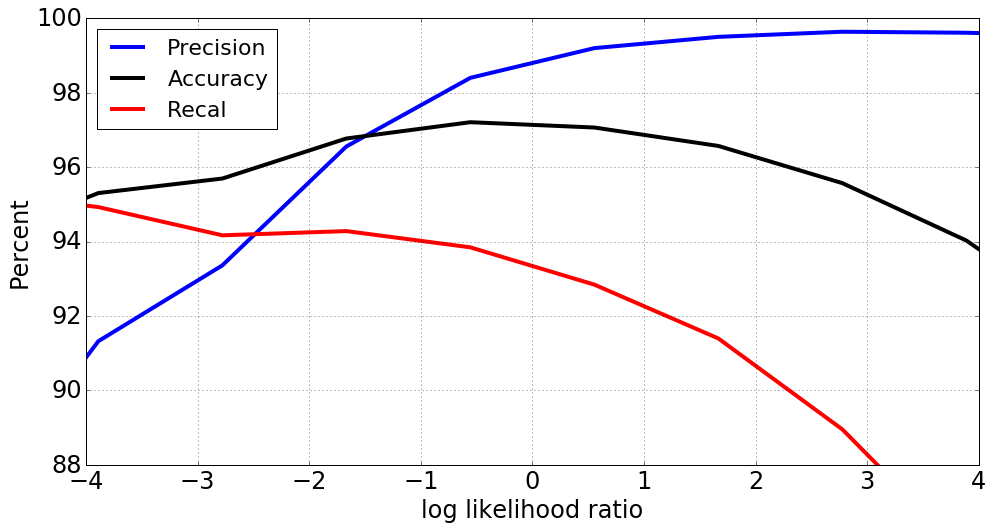

In [413]:
mean_A, mean_P, mean_R, mean_FN = [],[],[],[]
llrs=linspace(-5,5,10)
for llr in llrs:
    Prec,Rec, Acc, FN =[],[],[],[]
    for i in range(30):
        prec,rec,acc,fn=test_llr(0.5,llr)
        Prec.append(prec)
        Rec.append(rec)
        Acc.append(acc)
        FN.append(fn)
    mean_P.append(mean(Prec)*100)
    mean_R.append(mean(Rec)*100)
    mean_A.append(mean(Acc)*100)
    mean_FN.append(mean(FN)*100)
    
plt.plot(llrs,mean_P,'b',linewidth=4,label='Precision')
plt.plot(llrs,mean_A,'k',linewidth=4,label='Accuracy')
plt.plot(llrs,mean_R,'r',linewidth=4,label='Recal')

xlabel('log likelihood ratio')
ylabel('Percent')
grid()
ylim([88,100])
xlim([-4,4])
xticks(range(-4,5))
plt.legend(fontsize=22,loc='upper left')

<h3> To optimize the accuracy the decision boundry shuold be LLR=0, at which the precision is about 99% and the recall is 93.5% </h3>
<h3> In this case the goal should be identifying malignant tumors and the model should be optimized for precision, with a resonable recall. A good value for the LLR boundary is 1, at which the model has 99.0% precision with a decent 5% false-negative rate </h3>
<h3> The model could be tuned using the LLR for a specific need. From the population size being tested and the "cost" accosiated with false negatives we could easily compute this using the above plot</h3>

<h1> Overview: LLR=1 defines the highest precision with a resonable false negative rate </h1>

Accuracy: 96.931% <br>
Precission: 99.140% <br>
Recal: 92.549% <br>
Fraction of False Negatives: 4.236%

<h1> Step 5: Feature Importance </h1>

<h3> Make the ROC curve for each individual feature (use one profile at a time) </h3>

In [384]:
LLR_m_each=[]
LLR_b_each=[]

#run through each of the 9 features one at a time
for ii in range(9):
    N_m=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip([PDFs_B[ii]],[dataVals[ii]])] for dataVals in DF_M.values],1)
    D_m=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip([PDFs_M[ii]],[dataVals[ii]])] for dataVals in DF_M.values],1)
    LLR_m_each.append(N_m-D_m)

    N_b=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip([PDFs_B[ii]],[dataVals[ii]])] for dataVals in DF_B.values],1)
    D_b=sum([[log10(pdf[vals-1]) if pdf[vals-1]>0 else log10(1/1000) for pdf,vals in zip([PDFs_M[ii]],[dataVals[ii]])] for dataVals in DF_B.values],1)
    LLR_b_each.append(N_b-D_b)

#loop through each profile and calculate the LLR for each type (Malignant or Benine)
T1Fracs=[]
T2Fracs=[]
xbins=np.arange(-20,20,width)

for ii in range(9):
    nLLRT1, edgesT1 = histogram(LLR_m_each[ii],bins=xbins, normed=0)
    nLLRT2, edgesT2= histogram(LLR_b_each[ii],bins=xbins, normed=0)
    nLLRT1=nLLRT1/size(LLR_m_each[ii])
    nLLRT2=nLLRT2/size(LLR_b_each[ii])
    
    T2Fracs.append(cumsum(nLLRT2))
    T1Fracs.append(cumsum(nLLRT1))

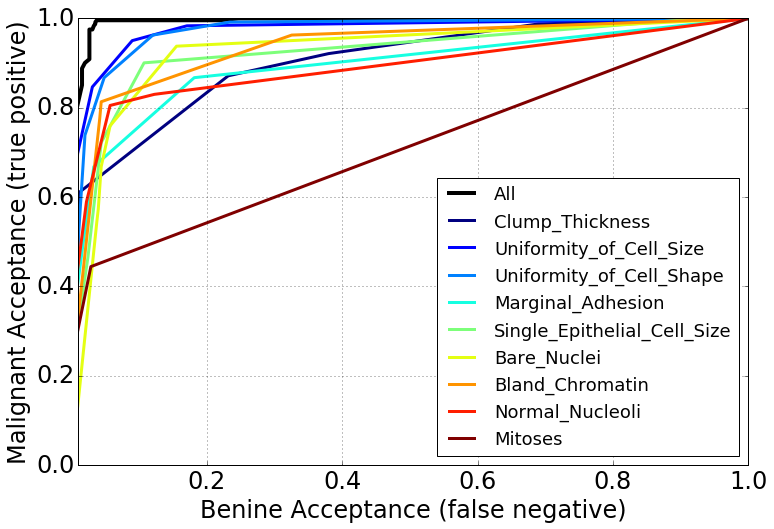

In [403]:
number_of_lines= 9
start=0
stop=1
cm_subsection = linspace(start, stop, number_of_lines) 
colors = [ cm.jet(x) for x in cm_subsection ]

plot(T2Frac,T1Frac,label='All',linewidth=4, color='k')
for ii in range(9):
    plot(T2Fracs[ii],T1Fracs[ii],label=names[ii+1],linewidth=3, color=colors[ii])

xlabel('Background Rejection')
ylabel('Signal Acceptance')
plt.legend(fontsize=18,loc='lower right')
#xscale('log')
xlim([1e-2,1])
ylim([0,1])
grid('on')

xlabel('Benine Acceptance (false negative)')
ylabel('Malignant Acceptance (true positive)')

<h3> The above plot shows the relative feature importance. The ROC curve is calculated for each feature individually and the combination of all the features is shown in black. </h3>
<h3> Clump Thickness and Uniformity of Cell Size are the two most important features for classifying a malignant cell </h3>
<h3> If we wanted to simplify the process for testing then maybe we can drop other variables. </h3>

<br>

<h3> Also, the Naive-Bayes assumption that L(a,b,c,d,e...)=L(a)*L(b)*L(c)*... was a decent approach because the product of the profiles produced an overall improved ROC curve. (black curve vs. the rest)</h3>

<h1> Hitting over 3h on this notebook so I'm stopping 🦄 </h1>

<p> Things I would have done next: </p>
<ol>
<li> Measure the correlation between variables </li>
<li> Test feature importace by removing Mitosis, Normal_Nucleoi, etc. from the model (only necessary if making any of thse measurements is a hastle and it would actually streamline the biopsy process.  </li>
<li> Use PCA to reduce the 9 features into 2 or 3 compnonets. Given a a reduced set of components build a 3D histogram for the profile likelihood anlysis. Defining the likelihood explicity as a function of 3 dimensions should be better than our initial assumption. L(x,y,z) vs. L(x)*L(y)*L(z). </li>
</ol>